<a href="https://colab.research.google.com/github/wasade/unifrac-colab-notebooks/blob/main/UniFrac_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# conda installation based on
# https://towardsdatascience.com/conda-google-colab-75f7c867a522

%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget --quiet https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT 
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX 
conda install -q --channel defaults conda python=3.8 --yes 
conda update -q --channel defaults --all --yes

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

Python 3.6.5 :: Anaconda, Inc.


In [16]:
%%bash

# install qiime2

wget https://data.qiime2.org/distro/core/qiime2-2021.11-py38-linux-conda.yml
conda env create -q -n qiime2-2021.11 --file qiime2-2021.11-py38-linux-conda.yml

--2022-02-17 17:04:04--  https://data.qiime2.org/distro/core/qiime2-2021.11-py38-linux-conda.yml
Resolving data.qiime2.org (data.qiime2.org)... 54.200.1.12
Connecting to data.qiime2.org (data.qiime2.org)|54.200.1.12|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://raw.githubusercontent.com/qiime2/environment-files/master/2021.11/release/qiime2-2021.11-py38-linux-conda.yml [following]
--2022-02-17 17:04:05--  https://raw.githubusercontent.com/qiime2/environment-files/master/2021.11/release/qiime2-2021.11-py38-linux-conda.yml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9452 (9.2K) [text/plain]
Saving to: ‘qiime2-2021.11-py38-linux-conda.yml.1’

     0K .........                                             100% 22.0M=0s

In [17]:
%%bash

# fetch the previously computed principal coordinates, metadata and biom table

wget --quiet -L "https://zenodo.org/record/6126424/files/out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qza?download=1" -O out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qza
wget --quiet -L "https://zenodo.org/record/6126147/files/metadata.tsv?download=1" -O metadata.tsv
wget --quiet -L "https://zenodo.org/record/6126308/files/330k.tree-overlap.biom?download=1" -O 330k.tree-overlap.biom

In [18]:
%%bash

# assess convex hulls subsampled from the principal coordinates space

# it doesn't seem we can switch to a conda env for cell execution,
# or at least easily, or in an obvious non-hacky way, so let's do stuff via 
# script
source activate qiime2-2021.11

python -c """
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import skbio
import scipy.spatial as spatial
import scipy.stats as ss
import qiime2

# load metadata and principal coordinates
df = pd.read_csv('metadata.tsv', sep='\t').set_index('#SampleID')
pc = qiime2.Artifact.load('out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qza').view(skbio.OrdinationResults)
df = df.loc[pc.samples.index]

volumes = []
areas = []
axes = [0, 1, 2]
total_hull = spatial.ConvexHull(pc.samples[axes].values)
total_volume = total_hull.volume
total_area = total_hull.area
for name, grp in df.groupby('qiita_empo_3'):
    # ignore those with not many samples and ignore blanks
    if len(grp) < 1000:
        continue
    if name == 'Sterile water blank':
        continue

    print(name, len(grp))
    for i in range(10):
        # randomly sample 1000 samples and compute the convex hull
        sample_subset = grp.sample(1000)
        subset = pc.samples.loc[sample_subset.index]
        hull = spatial.ConvexHull(subset[axes].values)
        volumes.append((name, i, hull.volume))
        areas.append((name, i, hull.area))
        
volumes = pd.DataFrame(volumes, columns=['EMPO3', 'iteration', 'volume'])
areas = pd.DataFrame(areas, columns=['EMPO3', 'iteration', 'area'])
volumes['volume'] /= total_volume
areas['area'] /= total_area

sns.boxplot(data=volumes, y='EMPO3', x='volume', linewidth=1)
ax = plt.gca()
ax.set_xlabel('Proportion of Convex Hull volume', fontsize=16)
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
plt.savefig('empo3-convexhull-volume.pdf')
plt.savefig('empo3-convexhull-volume.png')
"""

Animal corpus 16758
Animal distal gut 143530
Animal proximal gut 5218
Animal secretion 36743
Animal surface 33038
Plant surface 1925
Sediment (saline) 1690
Soil (non-saline) 12650
Surface (non-saline) 16579
Water (non-saline) 7263
Water (saline) 2293


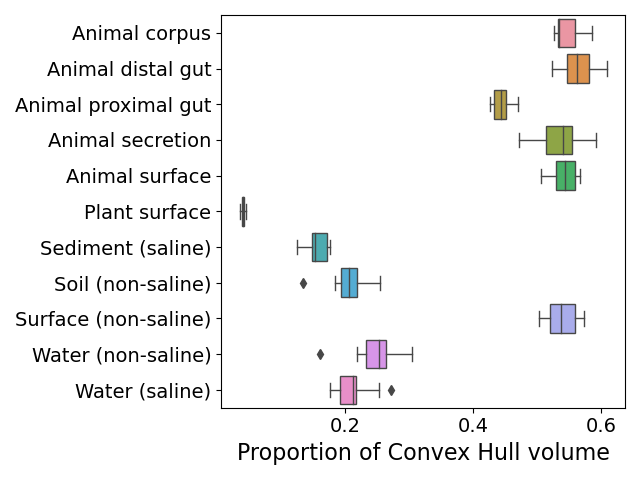

In [19]:
from IPython.display import Image
Image('empo3-convexhull-volume.png')

In [25]:
%%bash

# plot the benchmarking data

source activate qiime2-2021.11

python -c """
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# load all of our benchmark data
benchmark = pd.read_csv('https://zenodo.org/record/6117053/files/summary_300k_uw.csv?download=1')

# do some annotation and cleanup for the subsequent figure
benchmark['mobile-or-not'] = ['mobile' in v.lower() for v in benchmark['#test']]
benchmark['consumer-gpu'] = [v.split('_')[1] in {'Mobile1050', 'T4', 'RTX2080TI', 'RTX3090', 'RTX8000'}
                             for v in benchmark['#test']]
benchmark['is-cpu'] = [v.split('_')[1] in {'Xeon', 'MobileI7', 'MacI7'}
                       for v in benchmark['#test']]
benchmark['name'] = [v.split('_')[1] for v in benchmark['#test']]
benchmark.loc[0, 'name'] = 'Original (Xeon)'

legend_elements = [Patch(facecolor='black', edgecolor='black',
                         label='CPU'),
                   Patch(facecolor='white', edgecolor='black',
                         label='GPU')]               

coloring = {n: 'k' for n, v in zip(benchmark['name'], benchmark['is-cpu']) 
            if v}
coloring.update({n: 'w' for n, v in zip(benchmark['name'], benchmark['is-cpu'])
                 if not v})

sns.barplot(data=benchmark, x='name', y='runtime_hours', palette=coloring, edgecolor='k')
ax = plt.gca()
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Runtime log10(hours)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.legend(handles=legend_elements, loc='upper right', fontsize=16)
plt.tight_layout()
plt.savefig('benchmark-300k.png')
plt.savefig('benchmark-300k.pdf')
"""

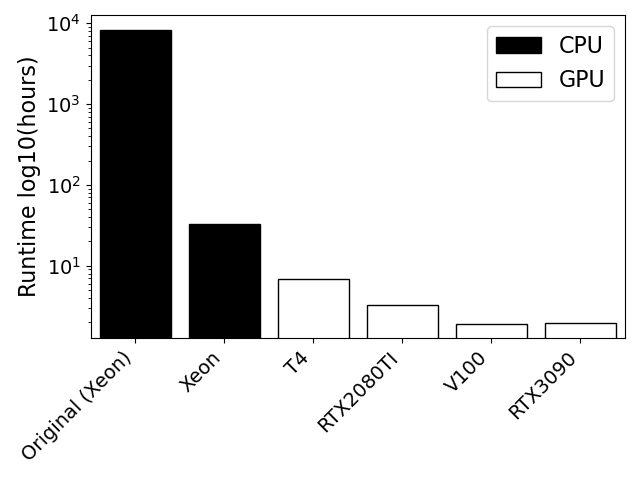

In [26]:
from IPython.display import Image
Image('benchmark-300k.png')

In [31]:
%%bash

# compute and plot sparsity measures for different environments

# NOTE: this we have reduced the number of ITERATIONS to 1 to reduce the total
# runtime for the purpose of an example notebook. The figure in the manuscript 
# used ITERATIONS=10

source activate qiime2-2021.11

python -c """
import pandas as pd
import numpy as np
import biom
import h5py

ITERATIONS = 1

# load metadata and define some variables
md = pd.read_csv('metadata.tsv', sep='\t').set_index('#SampleID')
category = 'qiita_empo_3'
depths = [#64,128,256,512,
          1024,2048,4096,8192]
f = h5py.File('330k.tree-overlap.biom')
ids = [i.decode('utf-8') for i in f['sample/ids']]

md = md.loc[list(ids)]

sparseness = []
samples_represented = set()
for cat, cat_grp in md.groupby(category):
    for depth in depths:
        # if we don't have enough samples, move on...
        if len(cat_grp) < depth:
            continue
        
        samples_represented.update(set(cat_grp.index))
        print(cat, depth, flush=True)
        for iter in range(ITERATIONS):
            # randomly pick the IDs
            id_set = [i.encode('ascii') for i in cat_grp.sample(depth).index]

            # loading direct from the table is about 4x faster than filtering the full table
            tab = biom.Table.from_hdf5(f, ids=id_set, subset_with_metadata=False).remove_empty()

            # compute and cache density
            density = tab.get_table_density()
            sparseness.append((cat, depth, iter, 1 - density, len(tab.ids()), len(tab.ids(axis='observation'))))

print('Percentage of samples represented: %0.2f' % ((len(samples_represented) / len(ids)) * 100))

df = pd.DataFrame(sparseness, columns=['category-value', 'depth', 'iteration', 'sparseness', 'number-of-samples', 'number-of-features'])
df.to_csv('sparseness.tsv', sep='\t', index=False, header=True)
"""


Animal corpus 1024
Animal corpus 2048
Animal corpus 4096
Animal corpus 8192
Animal distal gut 1024
Animal distal gut 2048
Animal distal gut 4096
Animal distal gut 8192
Animal proximal gut 1024
Animal proximal gut 2048
Animal proximal gut 4096
Animal secretion 1024
Animal secretion 2048
Animal secretion 4096
Animal secretion 8192
Animal surface 1024
Animal surface 2048
Animal surface 4096
Animal surface 8192
Plant surface 1024
Sediment (saline) 1024
Single strain 1024
Soil (non-saline) 1024
Soil (non-saline) 2048
Soil (non-saline) 4096
Soil (non-saline) 8192
Sterile water blank 1024
Sterile water blank 2048
Sterile water blank 4096
Sterile water blank 8192
Surface (non-saline) 1024
Surface (non-saline) 2048
Surface (non-saline) 4096
Surface (non-saline) 8192
Water (non-saline) 1024
Water (non-saline) 2048
Water (non-saline) 4096
Water (saline) 1024
Water (saline) 2048
Percentage of samples represented: 92.37


In [23]:
%%bash

source activate qiime2-2021.11

python -c """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('sparseness.tsv', sep='\t')
df['sparseness-log10'] = np.log10(df['sparseness'])
df['sparseness-percent'] = df['sparseness'] * 100
df['sparseness-percent-log10'] = np.log10(df['sparseness'] * 100)

df_top = df[df['depth'] >= 1000]
df_top = df[df['category-value'].isin(df_top['category-value'].unique())]
df_top = df_top[df_top['category-value'] != 'Sterile water blank']
df_top['EMPO3'] = df['category-value']

sns.lineplot(data=df_top, x='depth', y='sparseness-percent', hue='EMPO3', linewidth=.5, legend='brief')
ax = plt.gca()
ax.set_xlim(df_top['depth'].min(), df_top['depth'].max())
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of samples', fontsize=16)
ax.set_ylabel('Sparsity (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout()
plt.savefig('sparsity-empo3.png')
plt.savefig('sparsity-empo3.pdf')
"""

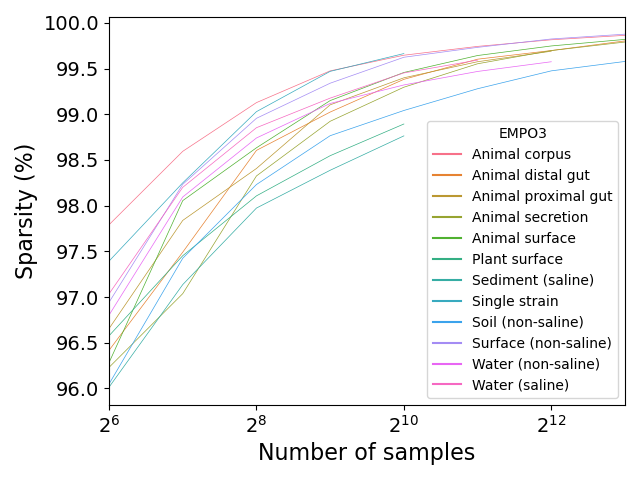

In [24]:
from IPython.display import Image
Image('sparsity-empo3.png')

In [27]:
%%bash

# construct an Emperor plot. Figure 1D used a screenshot from Emperor. The resulting
# .QZV can be viewed on https://view.qiime2.org.

source activate qiime2-2021.11

qiime emperor plot --i-pcoa out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qza --m-metadata-file metadata.tsv --o-visualization out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qzv

Saved Visualization to: out_330k_unweighted_fp32_f.hd5.t2.fsvd.anonymized.qzv
